In [1]:
import os
os.chdir('..')

In [2]:
from kg_rag.utility import *
from tqdm import tqdm
import pandas as pd
import spacy
import scispacy
from scispacy.linking import EntityLinker
from transformers import pipeline
from transformers import AutoModelForTokenClassification
from IPython.display import clear_output

/root/anaconda3/envs/kg_rag_test_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## List the NER methods to compare

In [3]:
method_list = ['gpt', 'biomed-ner-all', 'scispacy']


## Load spacy and bert based models

In [4]:
nlp = spacy.load("en_core_sci_sm")        
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})


biomed_ner_all_tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all",
                                         revision="main",
                                         cache_dir=config_data['LLM_CACHE_DIR'])
biomed_ner_all_model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all",                                             
                                    torch_dtype=torch.float16,
                                    revision="main",
                                    cache_dir=config_data['LLM_CACHE_DIR']
                                    )
clear_output()

## Load evaluation dataset

In [5]:
data = pd.read_csv('data/dataset_for_entity_retrieval_accuracy_analysis.csv')


## Custom functions

In [6]:
def entity_extraction(text, method):
    if method == 'gpt':
        start_time = time.time()
        entity = disease_entity_extractor_compare_version(text)
        run_time = time.time()-start_time
    elif method == 'scispacy':
        start_time = time.time()
        entity = disease_entity_extractor_scispacy(text)
        run_time = time.time()-start_time
    elif method == 'biomed-ner-all':
        start_time = time.time()
        entity = disease_entity_extractor_biomed_ner(text)
        run_time = time.time()-start_time
    return entity, run_time

def get_GPT_response_compare_version(instruction, system_prompt, chat_model_id, chat_deployment_id, temperature=0):
    return fetch_GPT_response(instruction, system_prompt, chat_model_id, chat_deployment_id, temperature)
    
def disease_entity_extractor_compare_version(text):
    chat_model_id, chat_deployment_id = get_gpt35()
    prompt_updated = system_prompts["DISEASE_ENTITY_EXTRACTION"] + "\n" + "Sentence : " + text
    resp = get_GPT_response_compare_version(prompt_updated, system_prompts["DISEASE_ENTITY_EXTRACTION"], chat_model_id, chat_deployment_id, temperature=0)
    try:
        entity_dict = json.loads(resp)
        return entity_dict["Diseases"]
    except:
        return None

def disease_entity_extractor_scispacy(text):
    doc = nlp(text)
    disease_semantic_types = {"T047", "T191"}    
    entity = []
    for ent in doc.ents:
        if ent._.kb_ents:
            umls_cui = ent._.kb_ents[0][0]
            umls_entity = nlp.get_pipe("scispacy_linker").kb.cui_to_entity[umls_cui]
            if any(t in disease_semantic_types for t in umls_entity.types):
                entity.append(ent.text)
    return entity

def disease_entity_extractor_biomed_ner(text):
    pipe = pipeline("ner", model=biomed_ner_all_model, tokenizer=biomed_ner_all_tokenizer, aggregation_strategy="simple", device=0)
    out = pipe(text)
    return list(filter(None, map(lambda x:x['word'] if x['entity_group']=='Disease_disorder' or x['entity_group']=='Sign_symptom' else None, out)))



In [7]:
%%time
comparison_out = []
for method_index, method in enumerate(method_list):
    print(f'Processing method : {method}, {method_index+1}/{len(method_list)}')
    for row_index, row in tqdm(data.iterrows()):
        entity, run_time = entity_extraction(row['text'], method)
        comparison_out.append((row['text'], row['node_hits'], entity, run_time, method))

comparison_out_df = pd.DataFrame(comparison_out, columns=['input_text', 'node_hits', 'entity_extracted', 'run_time_per_text', 'ner_method'])


Processing method : gpt, 1/3


322it [03:08,  1.71it/s]


Processing method : biomed-ner-all, 2/3


322it [00:09, 32.87it/s]


Processing method : scispacy, 3/3


322it [00:06, 52.28it/s]

CPU times: user 14.2 s, sys: 2.38 s, total: 16.6 s
Wall time: 3min 24s


In [8]:
comparison_out_df

,input_text,node_hits,entity_extracted,run_time_per_text,ner_method
0,LIRAGLUTIDE TREATS OBESITY,obesity,[obesity],1.076457,gpt
1,disease ontology identifier for central diabet...,central diabetes insipidus,[central diabetes insipidus],0.547419,gpt
2,"Xeroderma pigmentosum, group G is not associat...",xeroderma pigmentosum,[Xeroderma pigmentosum],0.533007,gpt
3,cherubism is not a autosomal dominant disease,cherubism,"[cherubism, autosomal dominant disease]",0.600985,gpt
4,MASA SYNDROME (DISORDER) IS NOT ASSOCIATED WIT...,MASA syndrome,[MASA SYNDROME],0.627725,gpt
...,...,...,...,...,...
961,antineoplastic agents treats osteosarcoma,osteosarcoma,[osteosarcoma],0.018100,scispacy
962,timothy syndrome associates gene cacna1c,Timothy syndrome,[syndrome],0.019820,scispacy
963,piebaldism is a autosomal dominant disease,piebaldism,[autosomal dominant disease],0.018688,scispacy
964,Disease ontology identifier for Loeys-Dietz sy...,Loeys-Dietz syndrome,[Loeys-Dietz syndrome],0.020629,scispacy


In [9]:
comparison_out_df_gpt = comparison_out_df[comparison_out_df.ner_method=='gpt']
comparison_out_df_biomed_ner_all = comparison_out_df[comparison_out_df.ner_method=='biomed-ner-all']
comparison_out_df_scispacy = comparison_out_df[comparison_out_df.ner_method=='scispacy']


In [10]:

def calculate_precision_recall(row):
    # Convert to lowercase and split node_hits into a list
    true_entities = set([row['node_hits'].lower()])
    
    # Convert extracted_entity list to lowercase
    predicted_entities = set([entity.lower() for entity in row['entity_extracted']])
    
    # Calculate true positives, false positives, and false negatives
    true_positives = len(true_entities.intersection(predicted_entities))
    false_positives = len(predicted_entities - true_entities)
    false_negatives = len(true_entities - predicted_entities)
    
    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return pd.Series({'precision': precision, 'recall': recall})

comparison_out_df_gpt[['precision', 'recall']] = comparison_out_df_gpt.apply(calculate_precision_recall, axis=1)
comparison_out_df_biomed_ner_all[['precision', 'recall']] = comparison_out_df_biomed_ner_all.apply(calculate_precision_recall, axis=1)
comparison_out_df_scispacy[['precision', 'recall']] = comparison_out_df_scispacy.apply(calculate_precision_recall, axis=1)

clear_output()

In [11]:
print(comparison_out_df_gpt.precision.mean())
print(comparison_out_df_gpt.recall.mean())

0.953416149068323
0.9968944099378882


In [12]:
print(comparison_out_df_biomed_ner_all.precision.mean())
print(comparison_out_df_biomed_ner_all.recall.mean())

0.23680124223602483
0.2795031055900621


In [13]:
print(comparison_out_df_scispacy.precision.mean())
print(comparison_out_df_scispacy.recall.mean())

0.5910973084886129
0.6428571428571429


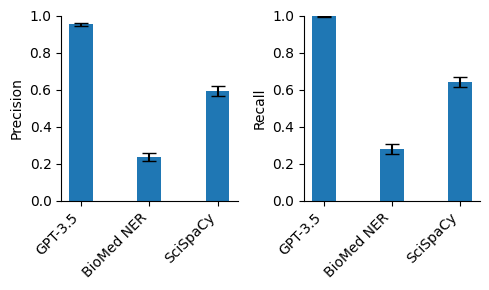

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these dataframes already loaded
# comparison_out_df_gpt
# comparison_out_df_biomed_ner_all
# comparison_out_df_scispacy

# Create a list of dataframes and their labels
dfs = [comparison_out_df_gpt, comparison_out_df_biomed_ner_all, comparison_out_df_scispacy]
labels = ['GPT-3.5', 'BioMed NER', 'SciSpaCy']

# Function to calculate SEM
def sem(data):
    return np.std(data, ddof=1) / np.sqrt(len(data))

# Calculate mean and SEM for precision and recall
precision_means = [df['precision'].mean() for df in dfs]
precision_sems = [sem(df['precision']) for df in dfs]
recall_means = [df['recall'].mean() for df in dfs]
recall_sems = [sem(df['recall']) for df in dfs]

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))
x = np.arange(len(labels))
width = 0.35

# Function to remove top and right spines
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Plot precision
ax1.bar(x, precision_means, width, yerr=precision_sems, capsize=5)
ax1.set_ylabel('Precision')
# ax1.set_title('Average Precision')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_ylim(0, 1)
remove_spines(ax1)

# Plot recall
ax2.bar(x, recall_means, width, yerr=recall_sems, capsize=5)
ax2.set_ylabel('Recall')
# ax2.set_title('Average Recall')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.set_ylim(0, 1)
remove_spines(ax2)

# Adjust layout and display
plt.tight_layout()
plt.show()

fig_path = 'data/results/figures'
os.makedirs(fig_path, exist_ok=True)
fig.savefig(os.path.join(fig_path, 'ner_extraction_comparison.svg'), format='svg', bbox_inches='tight')      


In [14]:
# # Print all labels
# # print(model.config.id2label)

# # Or, if you want a list of just the label names
# label_names = list(model.config.id2label.values())

# set(map(lambda x:x.split('-')[-1], label_names))

In [30]:
# method = method_list[0]
# text = data.iloc[25].text
# entity, run_time = entity_extraction(text, method)
# print(text)
# print(entity, run_time, method)
